<a href="https://colab.research.google.com/github/guillermohenrion/Intro-Python/blob/master/Data_preparation_%26_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Fronteras de decisión en árboles
* Particionamiento en función de lo que se quiere generalizar
* CV y CV estratificado
* Métricas con y sin balanceo: F1, F$\beta$, ROC, AUC, matriz de confusión, 
lift, ordenar por percentiles
* Calibración 



#Frontreas de decisión en árboles


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def dataset_sintetico_gausianas(means,covs,points,labels,seed=1234):
  all_dfs = []
  np.random.seed(seed)
  for mean_i,cov_i,points_i,label_i in zip(means,covs,points,labels):
    features_i = np.random.multivariate_normal(mean=mean_i, cov=cov_i,size=points_i)
    dataset_i = pd.DataFrame(features_i)
    dataset_i['Clase'] = label_i
    all_dfs.append(dataset_i)
  
  return pd.concat(all_dfs)


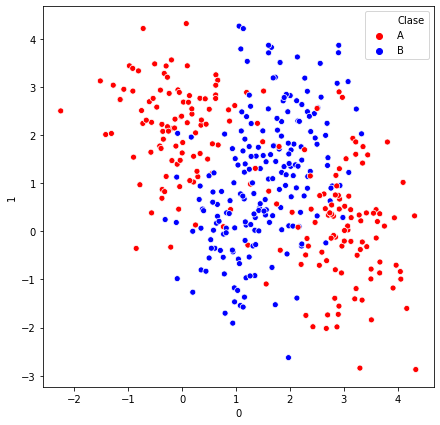

In [3]:
cov = [[0.4,0],[0,1.2]]
c1_mean = [0,2]
c2_mean = [1,0]
c3_mean = [2,2]
c4_mean = [3,0]

dataset = dataset_sintetico_gausianas([c1_mean,c2_mean,c3_mean,c4_mean],[cov,cov,cov,cov],[100,100,100,100],['A','B','B','A'])

plt.figure(figsize=(7,7))
sns.scatterplot(x=0,y=1,hue='Clase',data=dataset,palette={'A':'red','B':'blue'})

[Text(167.4, 181.2, 'X[0] <= 0.335\ngini = 0.5\nsamples = 400\nvalue = [200, 200]'),
 Text(83.7, 108.72, 'X[1] <= 0.678\ngini = 0.189\nsamples = 85\nvalue = [76, 9]'),
 Text(41.85, 36.23999999999998, 'gini = 0.496\nsamples = 11\nvalue = [5, 6]'),
 Text(125.55000000000001, 36.23999999999998, 'gini = 0.078\nsamples = 74\nvalue = [71, 3]'),
 Text(251.10000000000002, 108.72, 'X[0] <= 2.587\ngini = 0.477\nsamples = 315\nvalue = [124, 191]'),
 Text(209.25, 36.23999999999998, 'gini = 0.331\nsamples = 220\nvalue = [46, 174]'),
 Text(292.95, 36.23999999999998, 'gini = 0.294\nsamples = 95\nvalue = [78, 17]')]

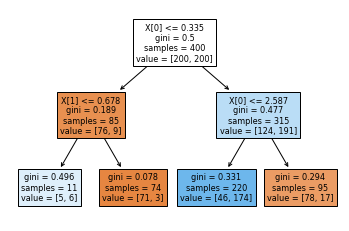

In [4]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(max_depth=2)
clf2 = tree.DecisionTreeClassifier(max_depth=15)
dataset.columns=['Col1', 'Col2', 'Clase']
clf = clf.fit(dataset[['Col1', 'Col2']], dataset['Clase'])
clf2 = clf2.fit(dataset[['Col1', 'Col2']], dataset['Clase'])
tree.plot_tree(clf, filled=True)



In [0]:
#tree.plot_tree(clf2, filled=True)

In [0]:
grid = np.meshgrid(np.arange(-3,6,0.1),np.arange(-3,6,0.1))
x_vals = grid[0].reshape(-1,1)
y_vals = grid[1].reshape(-1,1)

datos_frontera = pd.DataFrame(np.concatenate([x_vals,y_vals],axis=1))
datos_frontera2 = pd.DataFrame(np.concatenate([x_vals,y_vals],axis=1))

datos_frontera['Clase_Arbol1'] =clf.predict(datos_frontera)
datos_frontera2['Clase_Arbol2'] =clf2.predict(datos_frontera2)

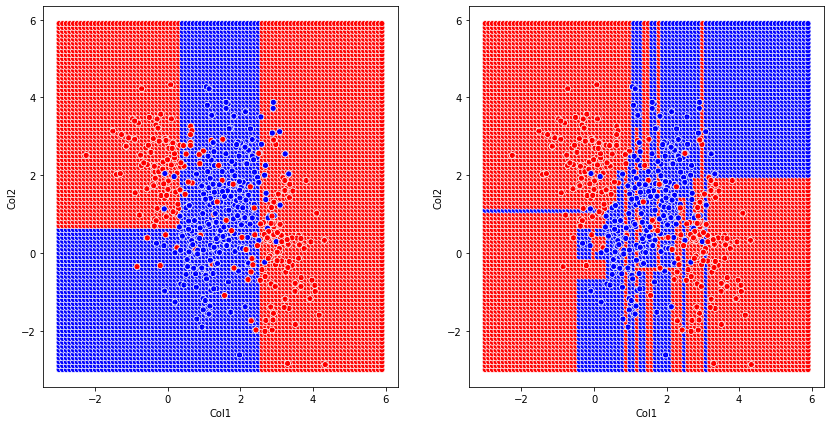

In [7]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(14,7))
sns.scatterplot(x=0,y=1,hue='Clase_Arbol1',data=datos_frontera,palette={'A':'red','B':'blue'},ax=ax[0])
sns.scatterplot(x='Col1',y='Col2',hue='Clase',data=dataset,palette={'A':'red','B':'blue'},ax=ax[0])
ax[0].get_legend().remove()

sns.scatterplot(x=0,y=1,hue='Clase_Arbol2',data=datos_frontera2,palette={'A':'red','B':'blue'},ax=ax[1])
sns.scatterplot(x='Col1',y='Col2',hue='Clase',data=dataset,palette={'A':'red','B':'blue'},ax=ax[1])
ax[1].get_legend().remove()

### Ejercicio 1 (15 minutos): Probar con distintas profundidades del árbol y sacar conclusiones

#División de datos Train-Validation-Test

In [0]:
from sklearn.datasets import load_breast_cancer

data_breast = load_breast_cancer()

Transformar el dataset en un dataframe:

In [0]:
df_data = pd.DataFrame(data_breast['data'],columns=data_breast['feature_names'])
df_data['target'] = data_breast['target']
features = data_breast['feature_names']
target = 'target'

Veamos qué tan balanceados están los datos:

In [10]:
df_data['target'].value_counts(normalize=True)

1    0.627417
0    0.372583
Name: target, dtype: float64

Dividamos los datos usando splits de entrenamiento, validacion y prueba. Hagamos 70, 15, 15.

In [0]:
#Con sklearn podemos dividir nuestros datos en conjuntos de entrenamiento, validación y prueba.

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_data[features].values, df_data[target].values, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test,y_test,test_size=0.5)

Podemos ver ahora como quedo

In [12]:
print('Entrenamiento: {}'.format(len(x_train)))
print('Validacion: {}'.format(len(x_val)))
print('Prueba: {}'.format(len(x_test)))

Entrenamiento: 398
Validacion: 85
Prueba: 86


Tambien podemos ver como quedaron balanceadas las clases en cada split:

In [13]:
for split_name, split in zip(['Entrenamiento','Validacion','Prueba'],[y_train,y_val,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[0]))

Entrenamiento: 0.374
Validacion: 0.400
Prueba: 0.337


Se puede observar que en cada uno de los splits, la proporción de las clases, por hacerse aleatoriamente la división, es distinta. Esto podría llegar a afectarnos. Una posibilidad es hacer splits estratificados:

In [0]:
x_train, x_test, y_train, y_test = train_test_split(df_data[features].values, df_data[target].values, test_size=0.3, random_state=42,stratify=df_data[target].values)
x_val, x_test, y_val, y_test = train_test_split(x_test,y_test,test_size=0.5,stratify=y_test)

In [15]:
print('Entrenamiento: {}'.format(len(x_train)))
print('Validacion: {}'.format(len(x_val)))
print('Prueba: {}'.format(len(x_test)))

Entrenamiento: 398
Validacion: 85
Prueba: 86


Ahora los splits tienen mas o menos el mismo balance

In [16]:
for split_name, split in zip(['Entrenamiento','Validacion','Prueba'],[y_train,y_val,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[0]))

Entrenamiento: 0.372
Validacion: 0.376
Prueba: 0.372


Vamos a separarnos un set de evaluación



In [0]:
x_train, x_test, y_train, y_test = train_test_split(df_data[features].values, df_data[target].values, test_size=0.3, random_state=42,stratify=df_data[target].values)

### Ejercicio 2 (15 minutos)

Hacer 100 divisiones distintas train-val. Medir accuracy, precision, recall y F1. Hacer un gráfico de caja y bigotes de estas métricas.

Comparar las gráficas de dos tipos de árboles:

* Árbol sencillo: profundidad < 10, min_samples_leaf>10, ccp_alpha=0.2

* Árbol complejo: profundidad > 20, min_samples_leaf<5, ccp_alpha=0

¿Cómo varían las distribuciones? ¿Por qué?


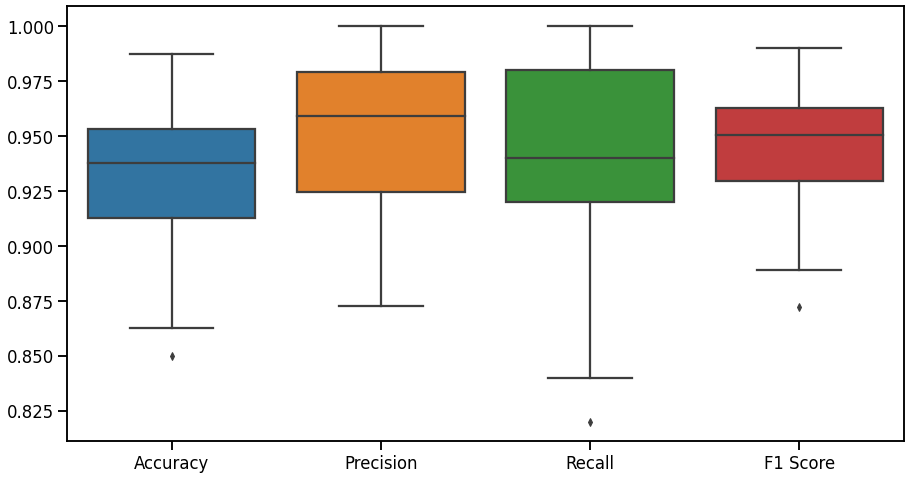

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_score, fbeta_score
import seaborn as sns
import matplotlib.pyplot as plt

n_seeds = 100
accs = []
precisions = []
recalls = []
f1s = []

for seed in range(n_seeds):
  x_train_, x_val, y_train_, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=seed,stratify=y_train)
  arbol_sklearn = DecisionTreeClassifier(criterion='entropy',max_depth=20,min_samples_leaf=1, ccp_alpha=0)
  arbol_sklearn.fit(x_train_,y_train_)

  y_pred_val = arbol_sklearn.predict(x_val)
  accs.append(accuracy_score(y_val,y_pred_val))
  precisions.append(precision_score(y_val,y_pred_val))
  recalls.append(recall_score(y_val,y_pred_val))
  f1s.append(f1_score(y_val,y_pred_val))

all_metrics = accs + precisions + recalls + f1s
metric_labels = ['Accuracy']*len(accs) + ['Precision']*len(precisions) + ['Recall']*len(recalls) + ['F1 Score']*len(f1s)

sns.set_context('talk')
plt.figure(figsize=(15,8))
sns.boxplot(metric_labels,all_metrics)

#Búsqueda de hiperparámetros y CV

Ahora queremos entrenar árboles de decisión. Teníamos varios hiperparámetros para decidir, como la profundidad, función de costo, número de instancias mínimo en una hoja, etc... Con sklearn, es posible explorar combinaciones de estos hiperparámetros asi elegimos la que mejores resultados den.

Ahora bien, tenemos que elegir una métrica en base a la cual tomar la decisión, y tenemos que tener datos en los que evaluar. En lugar de usar splits de entrenamiento-validación, vamos a usar k-fold cross-validation.

In [0]:
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_predict
import numpy as np
features=df_data.columns[:-1]
target=df_data.columns[-1]

base_tree = DecisionTreeClassifier()
#y_pred = cross_val_predict(base_tree, df_data[features],df_data['target'], cv=5)
y_pred = cross_val_predict(base_tree, x_train,y_train, cv=5)


[[28  2]
 [ 3 47]]
[[27  3]
 [ 1 49]]
[[26  4]
 [ 5 45]]
[[27  2]
 [ 1 49]]
[[25  4]
 [ 4 46]]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa33333f8d0>]],
      dtype=object)

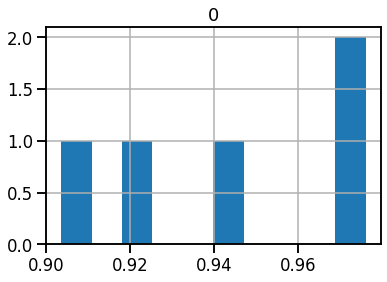

In [20]:
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
  
tree = DecisionTreeClassifier()
kfoldcv = StratifiedKFold(n_splits=5)
training_set=df_data
x=pd.DataFrame(x_train)
y=pd.DataFrame(y_train)
x.columns=features
y.columns=[target]
score=[]

training_set=pd.concat([x,y], axis=1)

for idx_train, idx_val in kfoldcv.split(training_set[features].values,training_set[target].values):
  x_train = training_set[features].values[idx_train]
  y_train = training_set[target].values[idx_train]
  x_val = training_set[features].values[idx_val]
  y_val = training_set[target].values[idx_val]

  tree.fit(x_train,y_train)
  y_pred = tree.predict(x_val)
  score.append(fbeta_score(y_val,y_pred,2))
  print(confusion_matrix(y_val,y_pred))
  
pd.DataFrame(score).hist()

### Ejercicio 3 (15 minutos): Probar con distintos valores de k y distintas métricas

In [0]:
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
import numpy as np

params_grid = {'criterion':['gini','entropy'],
               'max_depth':list(range(1,30)),
               'ccp_alpha':np.linspace(0,0.5,100)}

kfoldcv = StratifiedKFold(n_splits=10)
base_tree = DecisionTreeClassifier()
scorer_fn = make_scorer(f1_score)
randomcv = RandomizedSearchCV(estimator=base_tree,param_distributions = params_grid,scoring=scorer_fn,cv=kfoldcv,n_iter=100)
randomcv.fit(x_train,y_train);

Podemos ver todas las combinaciones de parámetros y qué puntajes obtuvieron, junto a tiempos de entrenamiento y predicción.

In [22]:
pd.DataFrame(randomcv.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_criterion,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004402,0.000890,0.001252,0.000333,25,gini,0.181818,"{'max_depth': 25, 'criterion': 'gini', 'ccp_al...",0.952381,0.705882,0.871795,0.909091,0.878049,0.904762,0.909091,0.900000,0.857143,0.923077,0.881127,0.063795,20
1,0.003643,0.000052,0.001151,0.000051,2,entropy,0.10101,"{'max_depth': 2, 'criterion': 'entropy', 'ccp_...",0.952381,0.705882,0.918919,0.909091,0.878049,0.871795,0.909091,0.918919,0.930233,0.894737,0.888910,0.065035,13
2,0.004103,0.000434,0.001167,0.000034,12,gini,0.116162,"{'max_depth': 12, 'criterion': 'gini', 'ccp_al...",0.952381,0.705882,0.871795,0.909091,0.878049,0.904762,0.909091,0.900000,0.857143,0.923077,0.881127,0.063795,20
3,0.004689,0.000114,0.001173,0.000034,3,entropy,0.388889,"{'max_depth': 3, 'criterion': 'entropy', 'ccp_...",0.918919,0.705882,0.871795,0.909091,0.878049,0.871795,0.909091,0.900000,0.888889,0.894737,0.874825,0.058388,51
4,0.004541,0.001166,0.001296,0.000294,14,gini,0.217172,"{'max_depth': 14, 'criterion': 'gini', 'ccp_al...",0.952381,0.705882,0.871795,0.909091,0.878049,0.904762,0.909091,0.900000,0.857143,0.923077,0.881127,0.063795,20


Podemos pedir cuál fue el mejor árbol:

In [23]:
randomcv.best_params_

{'ccp_alpha': 0.015151515151515152, 'criterion': 'entropy', 'max_depth': 24}

Metricas

In [24]:
from sklearn.metrics import confusion_matrix, classification_report

best_model = randomcv.best_estimator_
y_pred = best_model.predict(x_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88        64
           1       0.94      0.91      0.92       107

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.90       171
weighted avg       0.91      0.91      0.91       171



Text(19.5, 0.5, 'True')

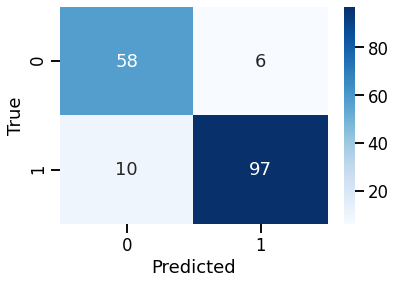

In [25]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')

A veces se utiliza la proporción de instancias en la hoja de la predicción como una probabilidad arrojada por el modelo. Si graficamos esas probabilidades para las instancias de ambas clases nos da algo asi:

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:330: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:330: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)


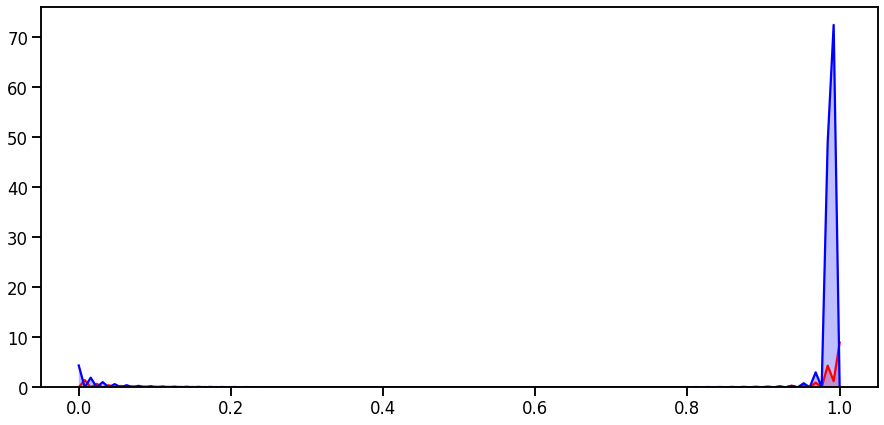

In [26]:
y_scores = best_model.predict_proba(x_test)
out_probs = y_scores[:,1]

plt.figure(figsize=(15,7))
sns.kdeplot(out_probs[y_test==0],shade=True,c='r')
sns.kdeplot(out_probs[y_test==1],shade=True,c='b')

El modelo nunca tiene incertidumbre (las probabilidades siempre estan cerca de 0 o 1, nunca de 0.5). Esto es porque justamente todas las hojas quedan bastante puras. Sin embargo, hay errores (curva roja donde debia estar azul y curva azul donde debia ser roja). Además se pueden observar picos, esto es porque las probabilidades son discretas en vez de continuas. Hay tantas probabilidades posibles como hojas tenga el árbol.

(0.0, 1.0)

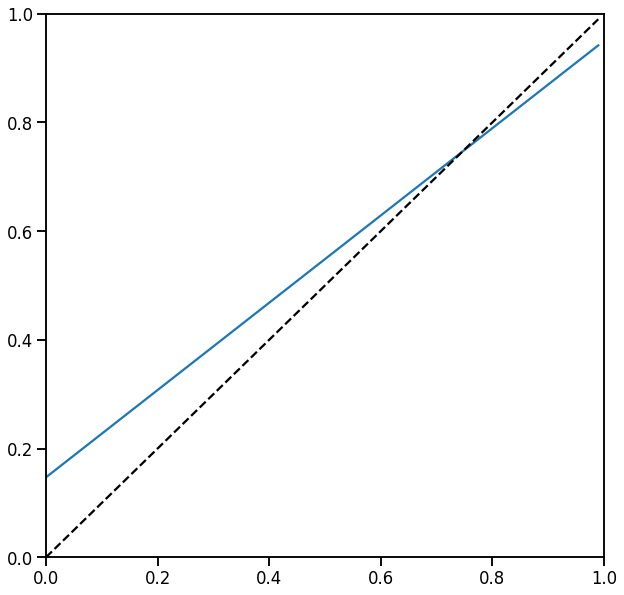

In [27]:
from sklearn.calibration import calibration_curve

fraction_of_positives, mean_predicted_value = calibration_curve(y_test,out_probs,n_bins=50)
plt.figure(figsize=(10,10))
plt.plot(mean_predicted_value,fraction_of_positives)
plt.plot(mean_predicted_value,mean_predicted_value,'k--')
plt.ylim(0,1)
plt.xlim(0,1)

El principal problema de los árboles de decisión es que overfitean facilmente y son muy sensibles a los datos de entrada. Más adelante en la teoría, se verán los random forests, que basicamente son muchos árboles juntos. Podemos probar mirar las probabilidades que devuelve un random forest.

In [0]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=200)
forest.fit(x_train,y_train)
y_pred_rf = forest.predict_proba(x_test)

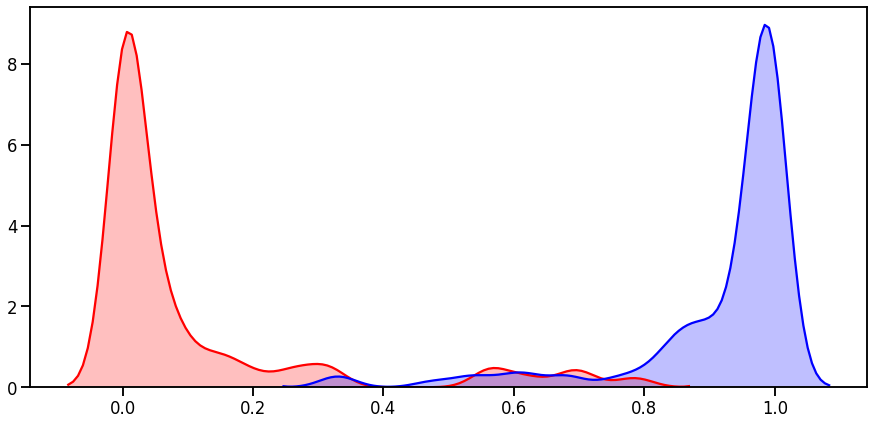

In [29]:
out_probs = y_pred_rf[:,1]

plt.figure(figsize=(15,7))
sns.kdeplot(out_probs[y_test==0],shade=True,color='r')
sns.kdeplot(out_probs[y_test==1],shade=True,color='b')

Al menos tiene mejor pinta... Veamos si está calibrado:

(0.0, 1.0)

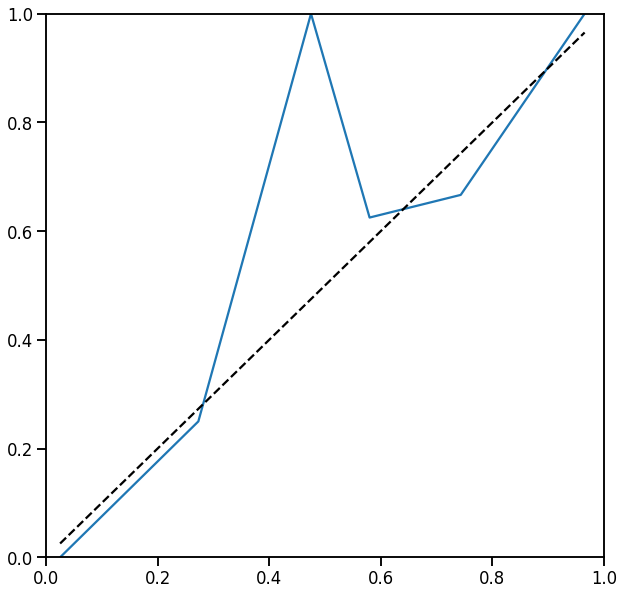

In [30]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_test,out_probs,n_bins=6)
plt.figure(figsize=(10,10))
plt.plot(mean_predicted_value,fraction_of_positives)
plt.plot(mean_predicted_value,mean_predicted_value,'k--')
plt.ylim(0,1)
plt.xlim(0,1)

In [31]:
fraction_of_positives

array([0.        , 0.25      , 1.        , 0.625     , 0.66666667,
       1.        ])

#Efecto del balance
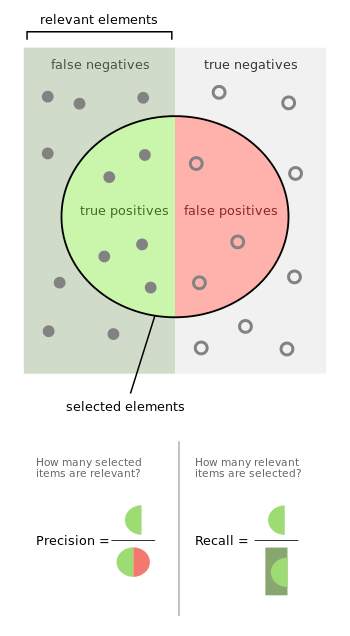

In [32]:
features=df_data.columns[:-1]
df_train=df_data

original_props = df_train['target'].value_counts(normalize=True)
original_counts = df_train['target'].value_counts()

instances_class0 = df_train[df_train['target'] == 0]
instances_class1 = df_train[df_train['target'] == 1]

desired_props = [0.05,0.15,0.25,0.5,0.75,0.85,0.95]
training_sets = []
for prop in desired_props:
  if prop>original_props[0]:
    needed_samples_0 = original_counts[0]
    needed_samples_1 = int(((1-prop)/prop)*original_counts[0])
  else:
    needed_samples_0 = int((prop/(1-prop))*original_counts[1])
    needed_samples_1 = original_counts[1]
  samples_0 = instances_class0.sample(n=needed_samples_0)
  samples_1 = instances_class1.sample(n=needed_samples_1)
  resampled_df = pd.concat([samples_0,samples_1])
  print(resampled_df['target'].value_counts(normalize=True))
  training_sets.append(resampled_df)

1    0.952
0    0.048
Name: target, dtype: float64
1    0.85
0    0.15
Name: target, dtype: float64
1    0.75
0    0.25
Name: target, dtype: float64
1    0.5
0    0.5
Name: target, dtype: float64
0    0.751773
1    0.248227
Name: target, dtype: float64
0    0.851406
1    0.148594
Name: target, dtype: float64
0    0.950673
1    0.049327
Name: target, dtype: float64


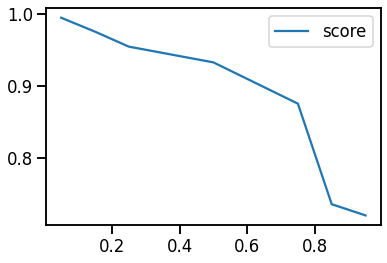

In [33]:
score=[]
for training_set in training_sets:
  tree = randomcv.best_estimator_
  kfoldcv = StratifiedKFold(n_splits=5)
  split_acc = []
  split_score = []
  for idx_train, idx_val in kfoldcv.split(training_set[features].values,training_set[target].values):
    x_train = training_set[features].values[idx_train]
    y_train = training_set[target].values[idx_train]
    x_val = training_set[features].values[idx_val]
    y_val = training_set[target].values[idx_val]

    tree.fit(x_train,y_train)
    y_pred = tree.predict(x_val)
    split_acc.append(accuracy_score(y_val,y_pred))
    split_score.append(fbeta_score(y_val,y_pred,2))
    #print(confusion_matrix(y_val,y_pred))
  #print(np.mean(split_score))
  score.append(np.mean(split_score))
pd_score=pd.DataFrame(score)
pd_score.columns=['score']
pd_score.index=desired_props  
pd_score.plot()


### Ejercicio 4 (15 minutos): Analizar resultados anteriores y sacar conclusiones 

# Curva ROC

0.814617406542056

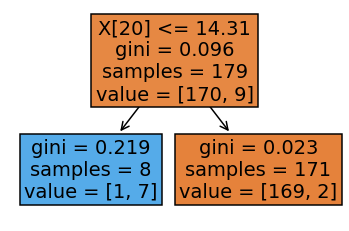

In [34]:
from sklearn.metrics import roc_curve
from sklearn import tree
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_score, fbeta_score

clf = tree.DecisionTreeClassifier(max_depth=1)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
tree.plot_tree(clf, filled=True)
roc_auc_score(y_test,y_pred)


### Ejercicio 5: Pensar en ROC si el modelo es árbol

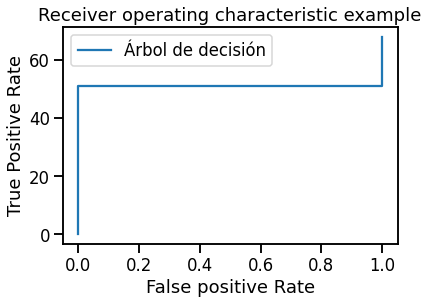

In [37]:
pd_roc=pd.concat([pd.DataFrame(y_pred), pd.DataFrame(y_test)], axis=1)
pd_roc.columns=['pred', 'test']
pd_roc.sort_values(by=['pred', 'test'], ascending=False)

roc=[]
for i in range(1, len(pd_roc)):
  pd_aux=pd_roc[:i]
  pd_tpr=pd_aux[(pd_aux['pred']==1) & (pd_aux['test']==1)]
  pd_fpr=pd_aux[(pd_aux['pred']==1) & (pd_aux['test']==0)]
  roc.append([len(pd_tpr), len(pd_fpr)])
tpr_fpr=pd.DataFrame(roc)
tpr_fpr.columns=['tpr','fpr']

plt.plot(tpr_fpr['fpr'], tpr_fpr['tpr'], label='Árbol de decisión')
plt.xlabel('False positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend()
plt.show()


[ROC Curve](http://arogozhnikov.github.io/2015/10/05/roc-curve.html)